In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
import warnings


In [2]:
df = pd.read_csv('/Users/spark/OneDrive/ps/AIBI/Wine/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from lightgbm import plot_importance, plot_metric, plot_tree

In [5]:
# creating X and y
X = df.drop('quality', axis = 1)
y = df['quality']


In [6]:
# splitting data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)

In [7]:
# scaling data
sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
X_train = pd.DataFrame(columns=X_train.columns, data=sc.fit_transform(X_train))
X_test = sc.transform(X_test)

train과 fit의 차이 
https://www.kaggle.com/questions-and-answers/65417

In [8]:
# import lightgbm as lgb

# lgb_dtrain = lgb.Dataset(data = X_train, label = y_train) # 학습 데이터를 LightGBM 모델에 맞게 변환
# lgb_param = {'max_depth': 10, # 트리 깊이
#             'learning_rate': 0.01, # Step Size
#             'n_estimators': 100, # Number of trees, 트리 생성 개수
#             'objective': 'multiclass', # 목적 함수
#             'num_class': len(y_train) + 1,
#             'force_col_wise':True } # 파라미터 추가, Label must be in [0, num_class) -> num_class보다 1 커야한다.
# lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
# lgb_model_predict = np.argmax(lgb_model.predict(X_test), axis = 1) # 평가 데이터 예측, Softmax의 결과값 중 가장 큰 값의 Label로 예측





In [9]:
# print("Accuracy: %.2f" % (accuracy_score(y_test, lgb_model_predict) * 100), "%") # 정확도 % 계산
# print('오차행렬:\n',confusion_matrix(y_test,lgb_model_predict))

In [10]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]

lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', 
          eval_set=evals, verbose=True)

preds = lgbmc.predict(X_test)

lgbmc_acc = accuracy_score(y_test, lgbmc.predict(X_test))

[1]	valid_0's multi_logloss: 1.11209
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.07406
[3]	valid_0's multi_logloss: 1.03935
[4]	valid_0's multi_logloss: 1.00827
[5]	valid_0's multi_logloss: 0.983239
[6]	valid_0's multi_logloss: 0.964941
[7]	valid_0's multi_logloss: 0.950671
[8]	valid_0's multi_logloss: 0.938484
[9]	valid_0's multi_logloss: 0.93028
[10]	valid_0's multi_logloss: 0.918561
[11]	valid_0's multi_logloss: 0.90788
[12]	valid_0's multi_logloss: 0.899052
[13]	valid_0's multi_logloss: 0.894171
[14]	valid_0's multi_logloss: 0.891611
[15]	valid_0's multi_logloss: 0.884986
[16]	valid_0's multi_logloss: 0.884161
[17]	valid_0's multi_logloss: 0.881833
[18]	valid_0's multi_logloss: 0.882205
[19]	valid_0's multi_logloss: 0.879607
[20]	valid_0's multi_logloss: 0.878408
[21]	valid_0's multi_logloss: 0.878042
[22]	valid_0's multi_logloss: 0.876213
[23]	valid_0's multi_logloss: 0.875593
[24]	valid_0's multi_logloss: 0.876251
[25]	valid_0's mu

In [11]:
cross_val = cross_validate(
    estimator=lgbmc,
    X=X, y=y,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 1.7991762638092041 (+/- 0.1816298076566277)
avg score time: 0.011945676803588868 (+/- 0.0011309216595981023)
avg test score: 0.5447237460815046 (+/- 0.02995080073642768)


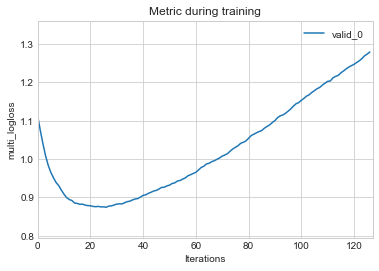

In [12]:
plot_metric(lgbmc);

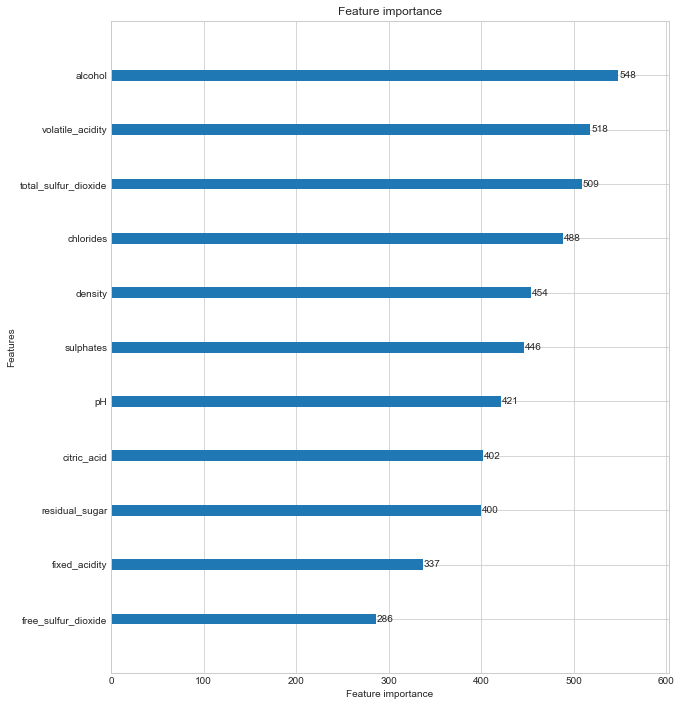

In [13]:
plot_importance(lgbmc,figsize=(10, 12));
#주요변수 alcohol, volatile acidity,total sulfur dioxide

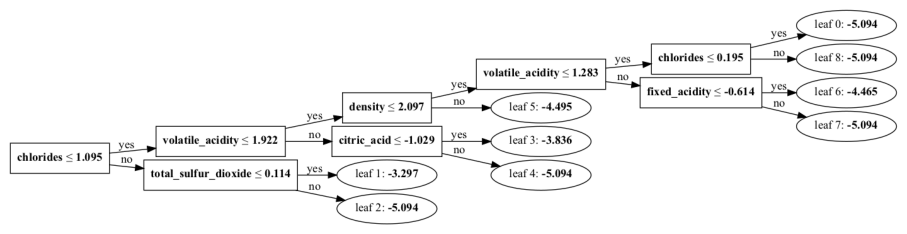

In [14]:
plot_tree(lgbmc, figsize=(16,10));

In [15]:
print(f"Training Accuracy of LGBM Classifier is {accuracy_score(y_train, lgbmc.predict(X_train))}")
print(f"Test Accuracy of LGBM Classifier is {lgbmc_acc} \n")
print('오차행렬:\n',confusion_matrix(y_test,preds))

Training Accuracy of LGBM Classifier is 0.9733110925771477
Test Accuracy of LGBM Classifier is 0.6675 

오차행렬:
 [[  0   0   2   0   0   0]
 [  0   0  11   1   1   0]
 [  2   1 130  36   1   0]
 [  0   2  38 109  10   1]
 [  0   0   0  23  27   0]
 [  0   0   0   3   1   1]]
